In [4]:
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from datetime import date, timedelta, datetime
import re
import pandas as pd
import os

import seaborn as sns

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# run Proj2.py to fill a file up with pickles of data if you want to redo this workflow. if you are running this after 
#July22 you may need to update the dates in MakeURL.py



In [7]:
##this makes the dataframe
#list the files
filelist = os.listdir('Picklefolder/') 
#read them into pandas
df_list = [pd.read_pickle(f'Picklefolder/{file}') for file in filelist if file[0]!='.']
#concatenate them together
df = pd.concat(df_list,ignore_index=True)
df.tail(5)
#print(testy)



,0,1,2,3,4,5,6,7,8,9,10
21467,https://www.google.com/flights?hl=en#flt=SEA.O...,2019-10-31,SEA,ORD,3.83,160,11:30 P,5:20 A,American,AA1408,Boeing 737
21468,https://www.google.com/flights?hl=en#flt=SEA.O...,2019-10-31,SEA,ORD,3.90,175,7:00 A,12:54 P,United,UA2287,Boeing 737
21469,https://www.google.com/flights?hl=en#flt=SEA.O...,2019-10-31,SEA,ORD,3.97,175,11:04 A,5:02 P,United,UA278,Boeing 737
21470,https://www.google.com/flights?hl=en#flt=SEA.O...,2019-10-31,SEA,ORD,3.85,175,2:10 P,8:01 P,United,UA670,Boeing 737
21471,https://www.google.com/flights?hl=en#flt=SEA.O...,2019-10-31,SEA,ORD,3.78,182,5:55 P,11:42 P,Delta,DL853,Airbus A319


In [8]:
df.dtypes
name_dict={0:'URL',1:'Date',2:'Origin',3:'Destination',4:'FlightDuration',5:'Price',6:'Time_depart',
          7:'Time_arrive',8:'Airline',9:'FlightNumber',10:'PlaneType'}
df.rename(name_dict,axis=1,inplace=True)

In [9]:
#Cleaning up Data types

df["Price"] = pd.to_numeric(df["Price"], errors='coerce')
df["Date"] = pd.to_datetime(df["Date"])


df["Time_depart"] = df["Time_depart"].apply(lambda x: f'{x}M')
df["Time_arrive"] = df["Time_arrive"].apply(lambda x: f'{x}M')

df["Time_depart"] = pd.to_datetime(df["Time_depart"],format='%I:%M %p',errors='coerce')
df["Time_arrive"] = pd.to_datetime(df["Time_arrive"],format='%I:%M %p',errors='coerce')

df.dtypes

URL                       object
Date              datetime64[ns]
Origin                    object
Destination               object
FlightDuration           float64
Price                    float64
Time_depart       datetime64[ns]
Time_arrive       datetime64[ns]
Airline                   object
FlightNumber              object
PlaneType                 object
dtype: object

In [10]:
df2=df
df2=df2.dropna(axis=0)
#df.describe()
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20504 entries, 0 to 21471
Data columns (total 11 columns):
URL               20504 non-null object
Date              20504 non-null datetime64[ns]
Origin            20504 non-null object
Destination       20504 non-null object
FlightDuration    20504 non-null float64
Price             20504 non-null float64
Time_depart       20504 non-null datetime64[ns]
Time_arrive       20504 non-null datetime64[ns]
Airline           20504 non-null object
FlightNumber      20504 non-null object
PlaneType         20504 non-null object
dtypes: datetime64[ns](3), float64(2), object(6)
memory usage: 1.9+ MB


,URL,Date,Origin,Destination,FlightDuration,Price,Time_depart,Time_arrive,Airline,FlightNumber,PlaneType
0,https://www.google.com/flights?hl=en#flt=SEA.B...,2019-09-12,SEA,BOS,5.17,124.0,1900-01-01 15:25:00,1900-01-01 23:35:00,Delta,DL341,Boeing 737
1,https://www.google.com/flights?hl=en#flt=SEA.B...,2019-09-12,SEA,BOS,5.18,179.0,1900-01-01 23:59:00,1900-01-01 08:10:00,JetBlue,"(REGEXerror:, Airbus A320B6 498)","(REGEXerror:, Airbus A320B6 498)"
2,https://www.google.com/flights?hl=en#flt=SEA.B...,2019-09-12,SEA,BOS,5.33,184.0,1900-01-01 15:50:00,1900-01-01 00:10:00,Alaska,AS736,Boeing 737
3,https://www.google.com/flights?hl=en#flt=SEA.B...,2019-09-12,SEA,BOS,5.50,164.0,1900-01-01 07:50:00,1900-01-01 16:20:00,Delta,DL1163,Boeing 737
4,https://www.google.com/flights?hl=en#flt=SEA.B...,2019-09-12,SEA,BOS,5.37,179.0,1900-01-01 11:33:00,1900-01-01 19:55:00,JetBlue,"(REGEXerror:, Airbus A320B6 598)","(REGEXerror:, Airbus A320B6 598)"


In [11]:
#here we make the tables that will go through the model, all data, daily mins (per route), and daily avg (per route)
df2=df
df2=df2.dropna(axis=0)
df2= df2.drop(['URL','Origin','Time_depart','Time_arrive','FlightNumber','PlaneType'],axis=1)

#use this to get min of flights, it works
df_min=(df2.sort_values(['Price'], ascending=[True]).groupby(['Destination','Date'])
 .head(1))

#this takes daily averages
df_avg=df2.groupby(['Destination','Date'],as_index=False).mean()

#this keeps all flights, but renamed so we can mess with it without saving over data
df_all=df2


df_min.info()
df_avg.info()
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 15970 to 15135
Data columns (total 5 columns):
Date              1770 non-null datetime64[ns]
Destination       1770 non-null object
FlightDuration    1770 non-null float64
Price             1770 non-null float64
Airline           1770 non-null object
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 83.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 0 to 1769
Data columns (total 4 columns):
Destination       1770 non-null object
Date              1770 non-null datetime64[ns]
FlightDuration    1770 non-null float64
Price             1770 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 69.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20504 entries, 0 to 21471
Data columns (total 5 columns):
Date              20504 non-null datetime64[ns]
Destination       20504 non-null object
FlightDuration    20504 non-null float64
Price             20504 non-nul

In [12]:
##Use this block to makes days and block out the holidays for now until we figure out a feature mask for them
basedate = pd.Timestamp('2019-07-22')

cropdate=120

df_min['Days'] = df_min['Date'].apply(lambda x: (x - basedate).days)
mask = ((df_min['Days'] < cropdate))
df_min=df_min[mask]



df_avg['Days'] = df_avg['Date'].apply(lambda x: (x - basedate).days)
mask2 = ((df_avg['Days'] < cropdate))
df_avg=df_avg[mask2]



df_all['Days'] = df_all['Date'].apply(lambda x: (x - basedate).days)
mask3 = ((df_all['Days'] < cropdate))
df_all=df_all[mask3]



df_min.info()
df_avg.info()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318 entries, 15970 to 15135
Data columns (total 6 columns):
Date              1318 non-null datetime64[ns]
Destination       1318 non-null object
FlightDuration    1318 non-null float64
Price             1318 non-null float64
Airline           1318 non-null object
Days              1318 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 72.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318 entries, 0 to 1726
Data columns (total 5 columns):
Destination       1318 non-null object
Date              1318 non-null datetime64[ns]
FlightDuration    1318 non-null float64
Price             1318 non-null float64
Days              1318 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 61.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15817 entries, 0 to 21471
Data columns (total 6 columns):
Date              15817 non-null datetime64[ns]
Destination     

In [13]:
##lets get a linear regression going
df_min.corr()
#df_avg.corr()
#df_all.corr()

,FlightDuration,Price,Days
FlightDuration,1.000000,0.643074,-0.017119
Price,0.643074,1.000000,-0.387676
Days,-0.017119,-0.387676,1.000000


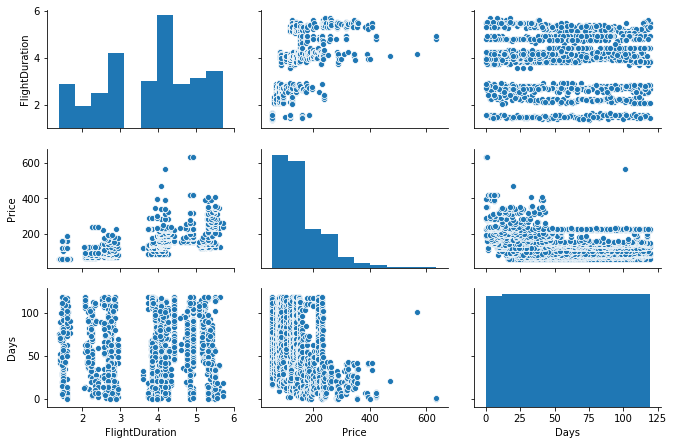

In [14]:
sns.pairplot(df_min, height=2.1, aspect=1.5);

In [16]:
##lets add some features for our model now##


##Destination dummies!!!!

df_min_dum = pd.concat([df_min, pd.get_dummies(df_min['Destination'])], axis=1)
df_avg_dum = pd.concat([df_avg, pd.get_dummies(df_avg['Destination'])], axis=1)
df_all_dum = pd.concat([df_all, pd.get_dummies(df_all['Destination'])], axis=1)

#Weekday dummies!!!!
df_min['weekday'] = df_min['Date'].dt.weekday_name
df_avg['weekday'] = df_avg['Date'].dt.weekday_name
df_all['weekday'] = df_avg['Date'].dt.weekday_name


df_min_dum_weekday = pd.concat([df_min, pd.get_dummies(df_min['weekday'])], axis=1)
df_avg_dum_weekday = pd.concat([df_avg, pd.get_dummies(df_avg['weekday'])], axis=1)
df_all_dum_weekday = pd.concat([df_all, pd.get_dummies(df_all['weekday'])], axis=1)


###price min reached dates!!!

Daymins=[21,28,35,42,49,56]
for days in Daymins:
    newcolumn = np.minimum(df_min.Days,days)
    df_min[f'Daysmin{days}']=newcolumn

for days in Daymins:
    newcolumn = np.minimum(df_avg.Days,days)
    df_avg[f'Daysmin{days}']=newcolumn
    
for days in Daymins:
    newcolumn = np.minimum(df_all.Days,days)
    df_all[f'Daysmin{days}']=newcolumn    

df_everything=pd.concat([df_all, pd.get_dummies(df_all['Destination'])], axis=1)
df_everything_min=pd.concat([df_min, pd.get_dummies(df_min['Destination'])], axis=1)

for days in Daymins:
    newcolumn = np.minimum(df_everything.Days,days)
    df_everything[f'Daysmin{days}']=newcolumn
    
for days in Daymins:
    newcolumn = np.minimum(df_everything_min.Days,days)
    df_everything_min[f'Daysmin{days}']=newcolumn    



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
df_all2=df_all
for days in Daymins:
    newcolumn = np.minimum(df_all.Days,days)
    df_all2[f'Advance_Days:{days}']=newcolumn  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1131]:
##These are all the data frames that you made to model on

#df_min_dum.head()
#df_avg_dum.head()
#df_all_dum.head()

#df_min_dum_weekday.head()
#df_avg_dum_weekday.head()
#df_all_dum_weekday.head()

#df_min.head()
#df_avg.head()
#df_all.head()

#df_everything.head()
#df_everything_min.head()

In [1268]:
##simple OLS of cities dummy, uncomment the y,x you want to run the model on that

#df_min_dum.head()  R2=0.63
#y,X= df_min_dum['Price'],df_min_dum.drop(['Price','Date','Destination','Airline'],axis=1)

#df_avg_dum.head()  R2=0.65
#y,X= df_avg_dum['Price'],df_avg_dum.drop(['Price','Date','Destination'],axis=1)

#df_all_dum.head() R2=0.53
#y,X= df_all_dum['Price'],df_all_dum.drop(['Price','Date','Destination','Airline'],axis=1)

In [20]:
##simple OLS of weekday dummy,uncomment the y,x you want to run the model on that

#df_min_dum_weekday.head()  R2=0.57
#y,X= df_min_dum_weekday['Price'],df_min_dum_weekday.drop(['Price','Date','Destination','Airline','weekday'],axis=1)

#df_avg_dum_weekday.head()  R2=0.62
#y,X= df_avg_dum_weekday['Price'],df_avg_dum_weekday.drop(['Price','Date','Destination','weekday'],axis=1)

#df_all_dum_weekday.head()  R2=0.85
#y,X= df_all_dum_weekday['Price'],df_all_dum_weekday.drop(['Price','Date','Destination','Airline','weekday'],axis=1)



In [1273]:
##Simple OLS of weekdaycutoff,uncomment the y,x you want to run the model on that
#df_min.head() R2=0.90
#y,X= df_min['Price'],df_min.drop(['Price','Date','Destination','Airline','weekday'],axis=1)

#df_avg.head()   R2=0.91
#y,X= df_avg['Price'],df_avg.drop(['Price','Date','Destination','weekday'],axis=1)

#df_all.head()   R2=0.86
#y,X= df_all['Price'],df_all.drop(['Price','Date','Destination','Airline','weekday'],axis=1)


In [1274]:
##simple OLS of everything model, uncomment the y,x you want to run the model on that

#y,X= df_everything['Price'],df_everything.drop(['Price','Date','Destination','Airline','weekday'],axis=1)


In [21]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [22]:
#model = sm.OLS(y, X)
model = sm.OLS(y_train_val, X_train_val)

In [23]:
fit = model.fit()

In [24]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     8152.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        00:43:03   Log-Likelihood:                -73468.
No. Observations:               12653   AIC:                         1.470e+05
Df Residuals:                   12644   BIC:                         1.470e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
FlightDuration    65.1836      0.331    196.782      0.000      64.534      65.833
Days              -0.7499      0.017    -43.000      0.000      -0.784      -0.716
Friday           -14.2948      7.885     -1.813      0.070     -29.751       1.162
Monday             3.6732      7.881      0.466      0.641     -11.775      19.122
Saturday          -6.1857      7.998     -0.773      0.439     -21.863       9.492
Sunday             4.7614      8.036      0.593      0.554     -10.991      20.513
Thursday           5.3959      8.077      0.668      0.504     -10.436      21.228
Tuesday           -1.8407      7.961     -0.231      0.817     -17.445      13.763
Wednesday         -2.3802      7.739     -0.308      0.758     -17.549      12.788
==============================================================================
Omnibus:                     4383.637   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37517.639
Skew:                           1.422   Prob(JB):                         0.00
Kurtosis:                      10.942   Cond. No.                         763.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

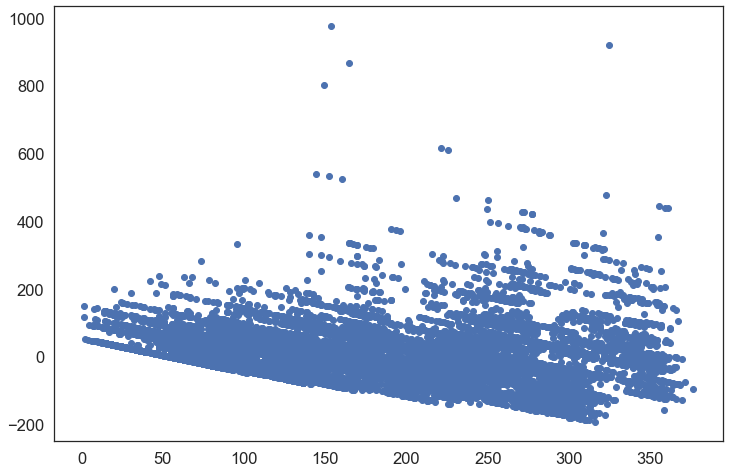

In [25]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

In [26]:
df_min.head()

,Date,Destination,FlightDuration,Price,Airline,Days,weekday,Daysmin21,Daysmin28,Daysmin35,Daysmin42,Daysmin49,Daysmin56
15970,2019-08-13,BOI,1.50,54.0,Alaska,22,Tuesday,21,22,22,22,22,22
14318,2019-10-17,BOI,1.62,54.0,Delta,87,Thursday,21,28,35,42,49,56
7655,2019-10-07,BOI,1.67,54.0,Alaska,77,Monday,21,28,35,42,49,56
1695,2019-09-20,BOI,1.50,54.0,Alaska,60,Friday,21,28,35,42,49,56
8189,2019-10-31,BOI,1.62,54.0,Delta,101,Thursday,21,28,35,42,49,56


In [ ]:
#### Now lets regularize our data using Lasso, and perform some model validation testing
##### we can start with our mins, and then work our way to all three data sets

In [27]:
#Models to test:

    # 1. df_min_dum - 
    # 2. df_all_dum - both 1 and 2 are city dummys only
    
    # 3. df_avg_dum_weekday  - looks at weekday factors on averages
    
    # 4. df_min
    # 5. df_all   - these look at the day step functions 
    
    # 6. df_everything
    # 7. df_everything_min   - these combine the city and day step function filter


## 1 and 2
    
#df_min_dum.head()  R2=0.63
#y,X= df_min_dum['Price'],df_min_dum.drop(['Price','Date','Destination','Airline'],axis=1)

#y = df_min_dum['Price']
#X = df_min_dum.loc[:,['FlightDuration','Days','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']]


#df_all_dum.head() R2=0.53
#y,X= df_all_dum['Price'],df_all_dum.drop(['Price','Date','Destination','Airline'],axis=1)

#y = df_all_dum['Price']
#X = df_all_dum.loc[:,['FlightDuration', 'Days','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']]




##  3 


#y = df_avg_dum_weekday['Price']
#X = df_avg_dum_weekday.loc[:,['FlightDuration','Days','Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']]



##   4 and 5 


#y = df_min['Price']
#X = df_min.loc[:,['FlightDuration','Days','Daysmin21','Daysmin28','Daysmin35','Daysmin42','Daysmin49','Daysmin56']]


#y = df_all['Price']
#X = df_all.loc[:,['FlightDuration','Days','Daysmin21','Daysmin28','Daysmin35','Daysmin42','Daysmin49','Daysmin56']]


#  6 and 7 


y = df_everything['Price']
X = df_everything.loc[:,['FlightDuration','Days','Daysmin35','Daysmin42',
                       'Daysmin49','Daysmin56','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']]

#y = df_everything_min['Price']
#X = df_everything_min.loc[:,['FlightDuration','Days','Daysmin35','Daysmin42',
       #                'Daysmin49','Daysmin56','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']]


In [30]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=13)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)


In [31]:
X_train.head()

,FlightDuration,Days,Daysmin35,Daysmin42,Daysmin49,Daysmin56,ATL,AUS,BOI,BOS,DEN,DTW,FAI,JFK,ORD,SAN,SFO
18659,2.75,41,35,41,41,41,0,0,0,0,1,0,0,0,0,0,0
10175,1.50,43,35,42,43,43,0,0,1,0,0,0,0,0,0,0,0
16812,2.50,24,24,24,24,24,0,0,0,0,0,0,0,0,0,0,1
18943,2.87,105,35,42,49,56,0,0,0,0,0,0,0,0,0,1,0
19295,2.17,53,35,42,49,53,0,0,0,0,0,0,0,0,0,0,1


In [32]:
X_train.shape

(9489, 17)

In [33]:
X_val.shape

(3164, 17)

In [34]:
X_test.shape

(3164, 17)

In [35]:
#min_weekdaycutoff, all weekday cutoff
#selected_columns = ['FlightDuration','Days','Daysmin21','Daysmin28','Daysmin35','Daysmin42','Daysmin49','Daysmin56']

#'Daysmin21','Daysmin28',


#min_weekday, all weekday
#selected_columns = ['FlightDuration','Days','Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']


#min_cities, all cities
#selected_columns = ['FlightDuration', 'Days','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']

#everything
selected_columns=['FlightDuration','Days','Daysmin35','Daysmin42',
                       'Daysmin49','Daysmin56','ATL','AUS','BOI','BOS','DEN','DTW','FAI','JFK','ORD','SAN','SFO']

In [64]:
lasso_model = Lasso(alpha = 4) 
lasso_model.fit(X_train.loc[:,selected_columns], y_train)

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [65]:
list(zip(selected_columns, lasso_model.coef_))

[('FlightDuration', 48.27881598002851),
 ('Days', -0.3003663113124893),
 ('Daysmin35', -2.264371293188433),
 ('Daysmin42', 0.0),
 ('Daysmin49', -0.0),
 ('Daysmin56', -0.6726630302531159),
 ('ATL', 0.0),
 ('AUS', -0.0),
 ('BOI', -0.0),
 ('BOS', -0.0),
 ('DEN', 0.0),
 ('DTW', 0.0),
 ('FAI', -0.0),
 ('JFK', -0.0),
 ('ORD', -0.0),
 ('SAN', -0.0),
 ('SFO', -0.0)]

In [38]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

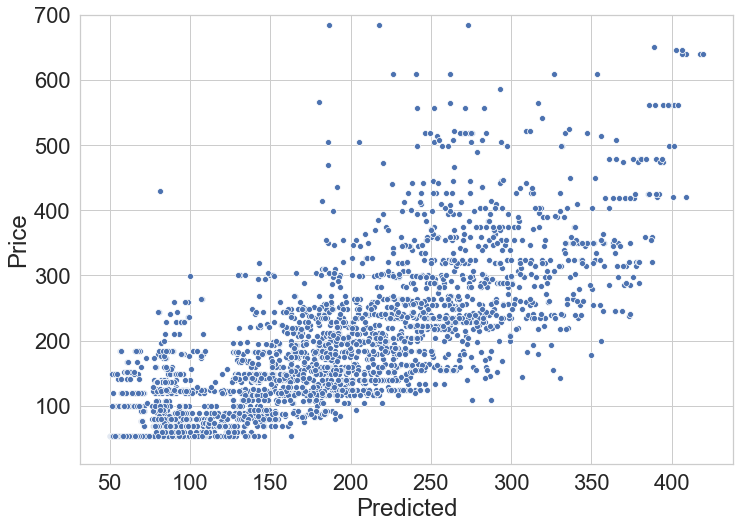

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.set(font_scale=2)
sns.set_style("whitegrid")
dg=sns.scatterplot(x=test_set_pred, y=y_test)
dg.set(ylim=(10, 700))
dg.set(xlabel='Predicted')


#dg=plt.scatter(test_set_pred, y_test, alpha=1)
#dg.set_size_inches(11.7, 8.27)
fig = dg.get_figure()
#fig.savefig("output.png")
fig.savefig('Modelstrengh.png', transparent=True,bbox_inches='tight')
#dg.set_ylabel('True Flight Price')
#dg.set_xlabel('Predicted Flight Price')


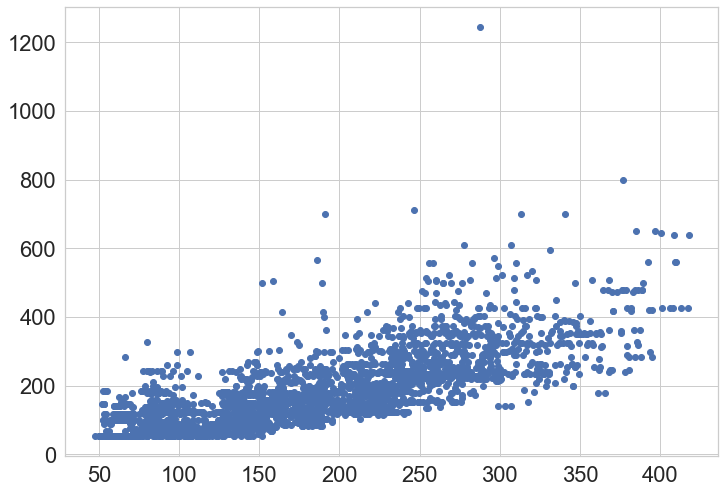

In [40]:
test_set_pred2 = lasso_model.predict(X_val.loc[:,selected_columns])
plt.scatter(test_set_pred2, y_val, alpha=1)

In [41]:
r2_score(y_test, test_set_pred)

0.5494201043200837

In [42]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

50.994609776999205

In [43]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))
max_iter=5000
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12100403.514391528, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11768742.468394998, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11432613.554357953, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11092401.0

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1925023.2356555276, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1721520.432163395, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528995.8924138695, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1348633.593

In [66]:
alphalist = 10**(np.linspace(-2,2,200))
Beta1 = np.zeros(len(alphalist))
Beta2 = np.zeros(len(alphalist))
Beta3 = np.zeros(len(alphalist))
Beta4 = np.zeros(len(alphalist))
max_iter=20
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    lasso_model = Lasso(alpha = curr_alpha) 
    lasso_model.fit(X_train.loc[:,selected_columns], y_train)
    
    Beta1[i] = lasso_model.coef_[2]
    Beta2[i] = lasso_model.coef_[3]
    Beta3[i] = lasso_model.coef_[4]
    Beta4[i] = lasso_model.coef_[5]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12100403.514391528, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21444996.380667955, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11768742.468394998, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21394480.6

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6523690.196779374, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20314052.520353924, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6181528.677294634, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20214945.680

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1721520.432163395, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17985195.262442447, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528995.8924138695, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17796270.02

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30306.70060927421, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14219104.615362888, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11995.705459550023, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13927503.59

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4024203.882835582, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3740966.672554739, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3466694.525884848, tolerance: 11194.887730761937
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3201790.76495

[('FlightDuration', 0.0), ('Days', -0.39667705845252516), ('Daysmin35', -0.0), ('Daysmin42', -0.0), ('Daysmin49', -0.0), ('Daysmin56', -1.6039056272814411), ('ATL', 0.0), ('AUS', 0.0), ('BOI', -0.0), ('BOS', 0.0), ('DEN', -0.0), ('DTW', 0.0), ('FAI', 0.0), ('JFK', 0.0), ('ORD', 0.0), ('SAN', -0.0), ('SFO', -0.0)]


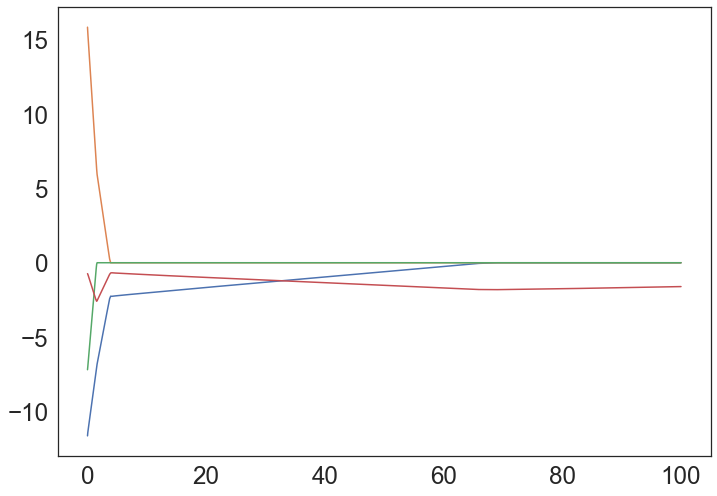

In [72]:
#you can use this to check that there is week model convergence, 
#whatever week persists as nonzero can be reported as the number of weeks. 

print(list(zip(selected_columns, lasso_model.coef_)))

plt.plot(alphalist, Beta1)
plt.plot(alphalist, Beta2)
plt.plot(alphalist, Beta3)
plt.plot(alphalist, Beta4)

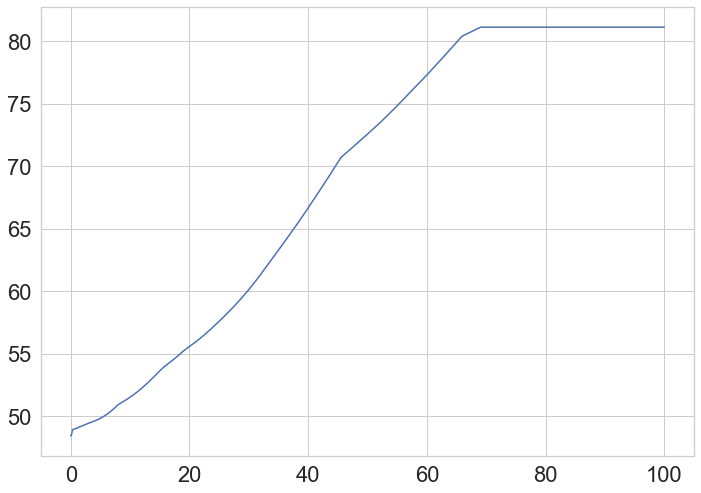

In [44]:
#plot the curve of validation error as alpha changes

plt.plot(alphalist, err_vec_val)

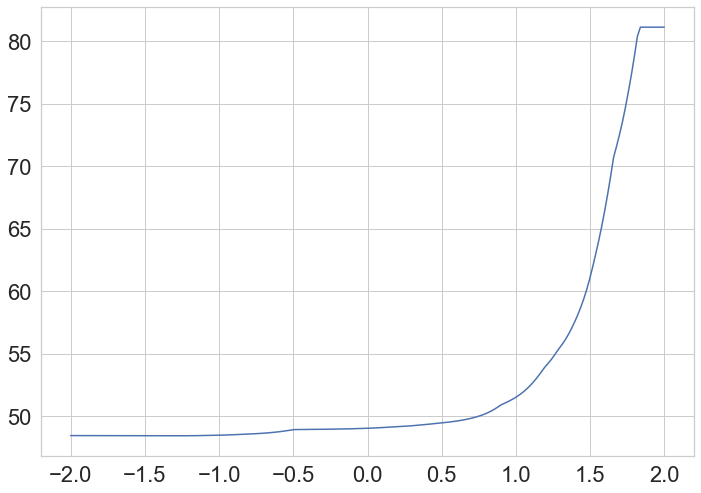

In [45]:
plt.plot(np.log10(alphalist), err_vec_val)

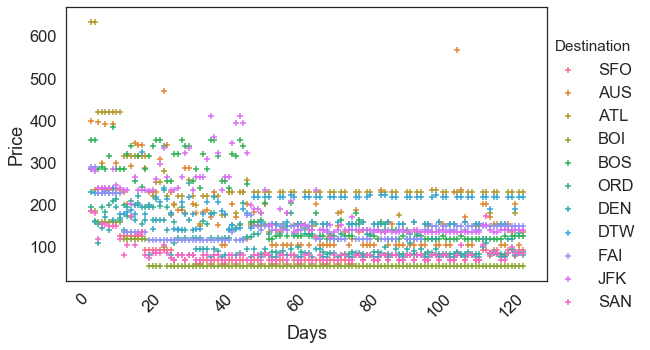

In [47]:
cities=['SFO','AUS','ATL','BOI','BOS','ORD','DEN','DTW','FAI','JFK','SAN']
sns.set(font_scale=1.5)
sns.set_style("white")

fg = sns.FacetGrid(data=df_min, hue='Destination', hue_order=cities, height=5, aspect=1.61, despine=False,);

fg.map(plt.scatter, 'Days', 'Price',marker="+").add_legend();
fg.set_xticklabels( rotation=45, horizontalalignment='right', color='k');


#fg.savefig('flights.png', transparent=True,bbox_inches='tight')


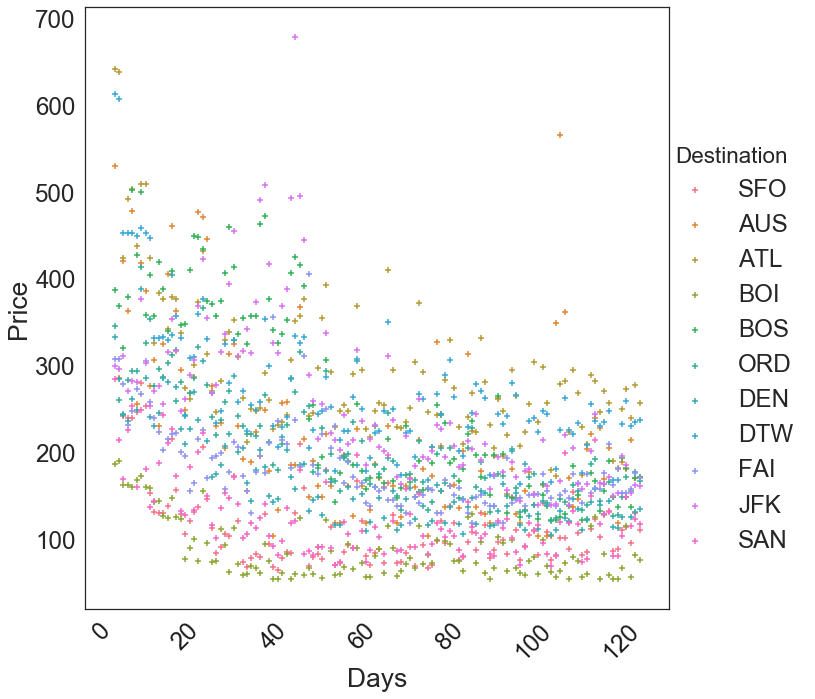

In [48]:

sns.set(font_scale=2.2)
sns.set_style("white")
fg = sns.FacetGrid(data=df_avg, hue='Destination', hue_order=cities, height=10, aspect=1, despine=False,);

fg.map(plt.scatter, 'Days', 'Price',marker="+").add_legend();
fg.set_xticklabels( rotation=45, horizontalalignment='right', color='k');

fg.savefig('avgflights.png', transparent=True,bbox_inches='tight')


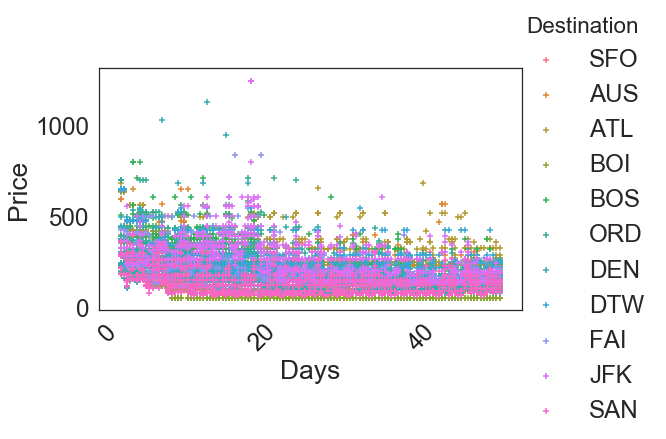

In [49]:
fg = sns.FacetGrid(data=df_all, hue='Destination', hue_order=cities, height=5, aspect=1.61, despine=False,);

fg.map(plt.scatter, 'Days', 'Price',marker="+" ).add_legend();
fg.set_xticklabels( rotation=45, horizontalalignment='right', color='k');


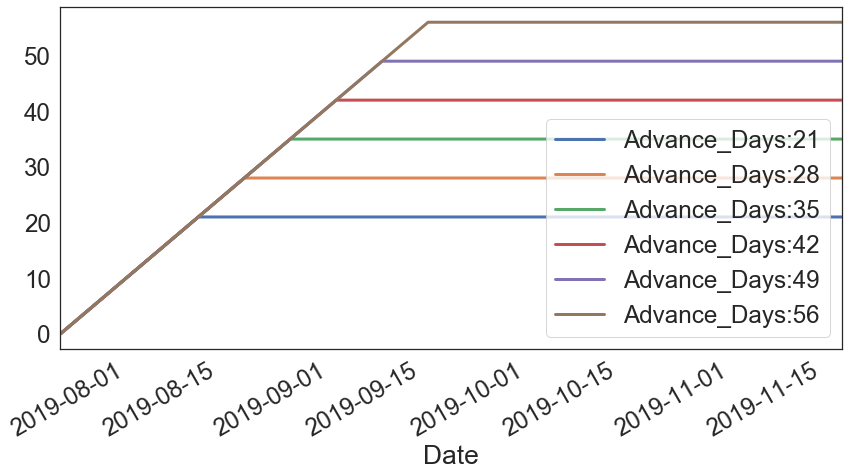

In [50]:

#df_avg.plot(x ='Date', y='Price',figsize=(11,7))
feature = df_all2.plot(x ='Date', y=['Advance_Days:21','Advance_Days:28','Advance_Days:35','Advance_Days:42','Advance_Days:49','Advance_Days:56'],figsize=(14,7),
                      linewidth=3.0)
#df_avg.plot(x ='Date', y='Daysmin35',figsize=(11,7))
fig = feature.get_figure()
fig.savefig('step.png', transparent=True,bbox_inches='tight')